In [54]:
# This file is used to get footprint plots.
import numpy as np
import matplotlib.pyplot as plt
import sinter
import scipy.stats
import pandas as pd

In [55]:
# get data for Teraquop simulation
file = "XZZXCZcompilationpFootprint_001/results.csv"
collected_stats = sinter.read_stats_from_csv_files(file)

In [56]:
# the collected data is a list of sinter.TaskStats containing the number of shots and number errors for each set of parameters (error_probability, eta, distance, rounds, ... )
print(collected_stats[0:1])

[sinter.TaskStats(strong_id='cccf0c94d23620ac1c81582df9a027700757617fcc71a9769a7f9420860bc89d', decoder='pymatching', json_metadata={'d': 9, 'eta': 10000, 'memory': 'V', 'p': 0.001, 'params': {'afterCZ_bias_probability': [0.001, 10000], 'after_clifford_depolarization': 0.001, 'after_reset_flip_probability': 0.001, 'before_measure_flip_probability': 0.001, 'before_round_data_bias_probability': [0.001, 10000], 'distance': 9, 'rounds': 27}}, shots=500000000, errors=7884, seconds=22956.830000000005)]


In [57]:
# Define the parameters we want to plot the teraquop footprint for:
P_PHYSICAL = [0.001]
ETA = [0.5,10,100,1000,10000]
MEMORY = "V" # "V" or "H"

# get relevant data
collected_stats = [stat for stat in collected_stats if stat.json_metadata['memory'] == MEMORY
                   and stat.json_metadata["eta"] in ETA
                   and stat.json_metadata["p"] in P_PHYSICAL]

In [58]:
# Get per round error and distance for each set of eta and p
fit_data = {}
for p in P_PHYSICAL:
    for eta in ETA:
        fit_data[(p, eta)] = {'xs': [], 'ys': []}

for stats in collected_stats:
    p = stats.json_metadata['p']
    eta = stats.json_metadata['eta']
    d = stats.json_metadata['d']
    if not stats.errors:
        print(f"Didn't see any errors for d={d}")
        continue
    
    # Get the MLE approximation and the error bars
    fit = sinter.fit_binomial(num_shots=stats.shots, num_hits=stats.errors, max_likelihood_factor=1000)
    # the number of rounds is contained in the params dictionary inside the json_metadata
    rounds = stats.json_metadata['params']['rounds']
    per_round = sinter.shot_error_rate_to_piece_error_rate(fit, pieces=rounds)
    fit_data[(p, eta)]['xs'].append(d)
    fit_data[(p, eta)]['ys'].append(per_round)

[9, 5, 7, 11, 13, 15, 17]
0.001
[9, 5, 7, 11, 13, 15, 17]
[9, 5, 7, 11, 13, 15]
0.001
[9, 5, 7, 11, 13, 15]
[9, 5, 7, 11, 13, 15]
0.001
[9, 5, 7, 11, 13, 15]
[9, 5, 7, 11, 13, 15]
0.001
[9, 5, 7, 11, 13, 15]
[9, 5, 7, 11, 13, 15]
0.001
[9, 5, 7, 11, 13, 15]


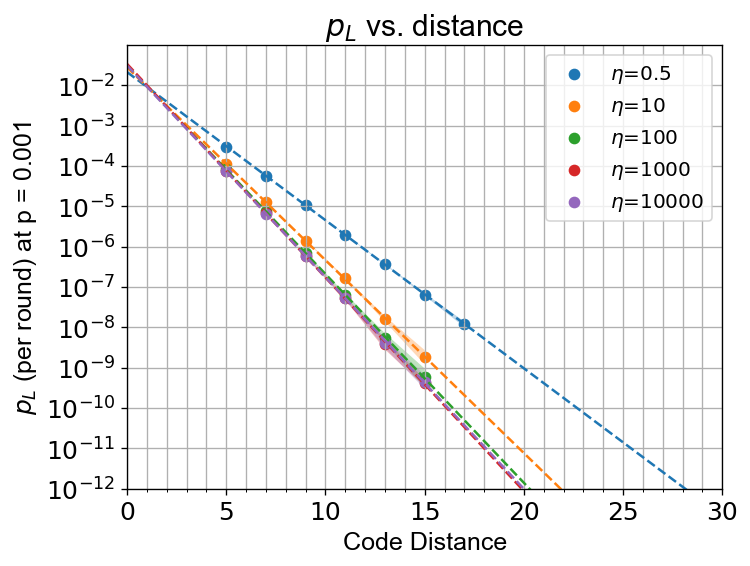

In [59]:
fig, ax = plt.subplots(1, 1)
max_distance = 30

for (p, eta), data in fit_data.items():
    xs = data['xs']
    ys = data['ys']
    print(xs)
    binom = {'best': [], 'low': [], 'high' : []}
    if len(xs) > 1:  # Need at least two points to fit a line
        for elem in ys:
            binom['best'].append(elem.best)
            binom['low'].append(elem.low)
            binom['high'].append(elem.high)
        fitBest = scipy.stats.linregress(xs, np.log(binom['best']))
        ax.scatter(xs, binom['best'], label=f"$\eta$={eta}")
        print(p)
        print(xs)
        # Plot fit
        plts = ax.plot([0, max_distance],
        [np.exp(fitBest.intercept), np.exp(fitBest.intercept + fitBest.slope * max_distance)],
        linestyle='--')
        # Add error bars to numerically obtained data
        ax.fill_between(xs, binom['low'],binom['high'],alpha=0.3,facecolor = plts[0].get_color())
        
    else:
        print(f"WARNING: Not enough data to fit a line for p={p}, eta={eta}")

ax.set_ylim(1e-12, 1e-1)
ax.set_xlim(0, max_distance)
ax.semilogy()
ax.set_title("$p_L$ vs. distance",fontname='Arial')
ax.set_xlabel("Code Distance",fontname='Arial')
ax.set_ylabel(f"$p_L$ (per round) at p = {p}" ,fontname='Arial')
ax.set_yticks([1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2])
ax.grid(which='major')
ax.grid(which='minor')
ax.minorticks_on()
ax.legend(prop={'size': 12})
fig.set_dpi(120)  # Show it bigger
plt.rcParams.update({'font.size': 15})
# plt. savefig("CZFootprint0_001.pdf", format="pdf", bbox_inches="tight")